In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

In [2]:
proposal_probs = {"grow" : 0.5,
                  "prune" : 0.5}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
np.set_printoptions(suppress=True)
print(y_train[:12])

[ 0.50327821  0.60672224  0.26898966  0.55211673  0.50693811  0.66162097
 -0.64127659  0.65112284  0.03487759  0.23276531  0.44055996  0.38216964]


In [3]:
#profiler = Profiler()
#profiler.start()
bart = ChangeNumTreeBART(ndpost=20000, nskip=0, n_trees=200, proposal_probs=proposal_probs)
bart.fit(X_train, y_train)
#profiler.stop()
#profiler.print()

Iterations: 100%|██████████| 20000/20000 [06:44<00:00, 49.50it/s]


In [4]:
bart.trace[-1].n_trees

52

In [5]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]

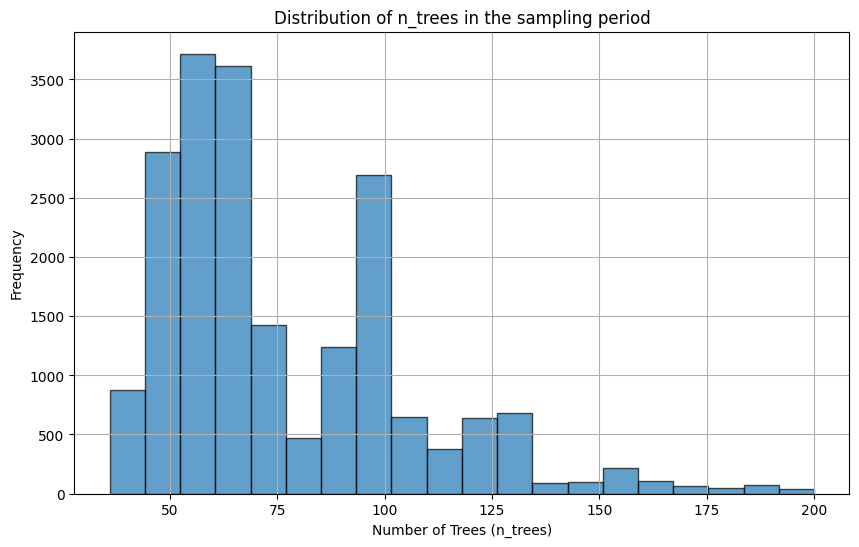

In [6]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

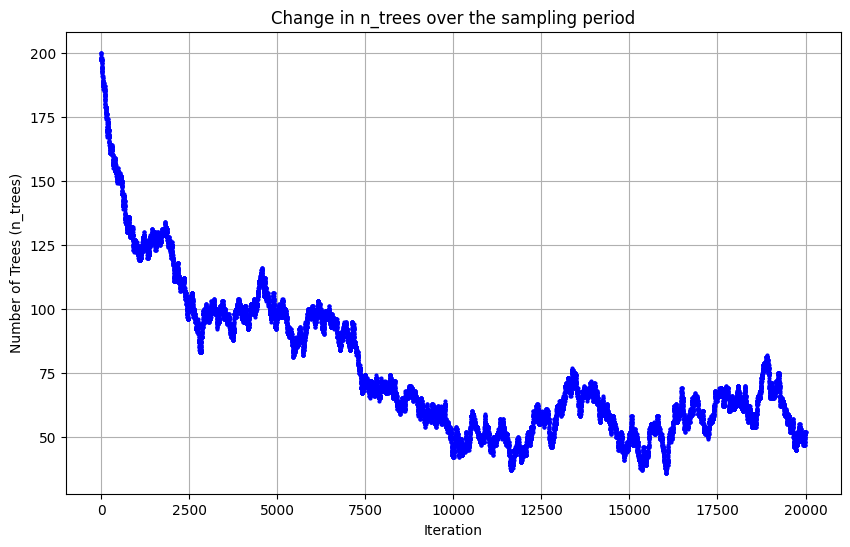

In [7]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [8]:
bart.trace[-1].trees

[Tree(vars=[ 0 -1 -1 -2], thresholds=[0.93321272        nan        nan        nan], leaf_vals=[       nan 0.02102025 0.02544494        nan], n_vals=[ -2 114  -2  -2]),
 Tree(vars=[ 1 -1 -1 -2], thresholds=[0.15225001        nan        nan        nan], leaf_vals=[0.02224857 0.00523124 0.01526078        nan], n_vals=[-2 18 -2 -2]),
 Tree(vars=[ 0 -1 -1 -2], thresholds=[0.92356431        nan        nan        nan], leaf_vals=[       nan 0.01472246 0.00097661        nan], n_vals=[-2 -2 -2 -2]),
 Tree(vars=[ 1  0  0 -1 -1  0 -1 -2 -2 -2 -2 -1 -1 -2 -2 -2], thresholds=[0.02123619 0.14958207 0.70359729        nan        nan 0.23392766
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan], leaf_vals=[        nan         nan         nan -0.00977732 -0.008704           nan
   0.00866208         nan         nan         nan         nan  0.01092762
  -0.01232953         nan         nan         nan], n_vals=[ -2   2 118   1   1  84  -2  -2

In [9]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-03-26 18:30:35,101:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-03-26 18:30:35,104:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.58 P_prune=0.42 A_grow=0.33 A_prune=0.23 (burnin)
Iteration 200/300 P_grow=0.52 P_prune=0.48 A_grow=0.37 A_prune=0.44
Iteration 300/300 P_grow=0.46 P_prune=0.54 A_grow=0.29 A_prune=0.43


In [10]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.16343908144144736,
 'rf': 0.01975318116019582,
 'lr': 0.048045521328019404,
 'btz': 0.025221175773841288}